複数のAdapterで最適化問題を解いて結果を比較する
=========================================

OMMX Adapterは共通化されたAPIを持っているので、複数のソルバーを使って同じ問題を解いて結果を比較することができます。まず例として簡単なナップザック問題を考えましょう：

$$
\begin{align*}
\mathrm{maximize} \quad & \sum_{i=0}^{N-1} v_i x_i \\
\mathrm{s.t.} \quad & \sum_{i=0}^{n-1} w_i x_i - W \leq 0, \\
& x_{i} \in \{ 0, 1\} 
\end{align*}
$$

In [1]:
from ommx.v1 import Instance, DecisionVariable

v = [10, 13, 18, 31, 7, 15]
w = [11, 25, 20, 35, 10, 33]
W = 47
N = len(v)

x = [
    DecisionVariable.binary(
        id=i,
        name="x",
        subscripts=[i],
    )
    for i in range(N)
]
instance = Instance.from_components(
    decision_variables=x,
    objective=sum(v[i] * x[i] for i in range(N)),
    constraints=[sum(w[i] * x[i] for i in range(N)) - W <= 0],
    sense=Instance.MAXIMIZE,
)

## 複数のソルバーで問題を解く

ここではOMMX SDK本体と一緒に開発されている以下のOSSへのAdapterを使いましょう。

| Package name | PyPI | Backend |
|:--- |:--- |:--- |
| `ommx-python-mip-adapter` | [![ommx-python-mip-adapter](https://img.shields.io/pypi/v/ommx-python-mip-adapter)](https://pypi.org/project/ommx-python-mip-adapter/) | [CBC](https://github.com/coin-or/Cbc) via [Python-MIP](https://github.com/coin-or/python-mip) |
| `ommx-pyscipopt-adapter` | [![ommx-pyscipopt-adapter](https://img.shields.io/pypi/v/ommx-pyscipopt-adapter)](https://pypi.org/project/ommx-pyscipopt-adapter/) | [SCIP](https://github.com/scipopt/scip) via [PySCIPOpt](https://github.com/scipopt/PySCIPOpt) |
| `ommx-highs-adapter` | [![ommx-highs-adapter](https://img.shields.io/pypi/v/ommx-highs-adapter)](https://pypi.org/project/ommx-highs-adapter/) | [HiGHS](https://github.com/ERGO-Code/HiGHS) |

OSSでないソルバーについても以下が存在し、同じインターフェースで使う事ができます。

| Package name | PyPI | Backend |
|:--- |:--- |:--- |
| [ommx-gurobipy-adapter](https://github.com/Jij-Inc/ommx-gurobipy-adapter) | [![ommx-gurobipy-adapter](https://img.shields.io/pypi/v/ommx-gurobipy-adapter)](https://pypi.org/project/ommx-gurobipy-adapter/) | [Gurobi](https://www.gurobi.com/) |
| [ommx-fixstars-amplify-adapter](https://github.com/Jij-Inc/ommx-fixstars-amplify-adapter) | [![ommx-fixstars-amplify-adapter](https://img.shields.io/pypi/v/ommx-fixstars-amplify-adapter)](https://pypi.org/project/ommx-fixstars-amplify-adapter/) | [Fixstars Amplify](https://amplify.fixstars.com/ja/docs/amplify/v1/index.html#) |

ここではOSSのHighs, Python-MIP(CBC), 及びSCIPのAdapterを使ってナップザック問題を解いてみましょう。

In [2]:
from ommx_python_mip_adapter import OMMXPythonMIPAdapter
from ommx_pyscipopt_adapter  import OMMXPySCIPOptAdapter
from ommx_highs_adapter      import OMMXHighsAdapter

# 利用するAdapterの一覧
adapters = {
    "highs": OMMXHighsAdapter,
    "cbc": OMMXPythonMIPAdapter,
    "scip": OMMXPySCIPOptAdapter,
}

# 各Adapterを介して問題を解く
solutions = {
    name: adapter.solve(instance) for name, adapter in adapters.items()
}

Cbc0038I Initial state - 1 integers unsatisfied sum - 0.457143
Cbc0038I Solution found of 28
Cbc0038I Before mini branch and bound, 5 integers at bound fixed and 0 continuous
Cbc0038I Full problem 1 rows 6 columns, reduced to 0 rows 0 columns
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I Round again with cutoff of 30.3171
Cbc0038I Reduced cost fixing fixed 1 variables on major pass 2
Cbc0038I Pass   1: suminf.    0.07474 (1) obj. 30.3171 iterations 1
Cbc0038I Pass   2: suminf.    0.45714 (1) obj. 42.1714 iterations 1
Cbc0038I Pass   3: suminf.    0.07474 (1) obj. 30.3171 iterations 1
Cbc0038I Pass   4: suminf.    0.45714 (1) obj. 42.1714 iterations 1
Cbc0038I Pass   5: suminf.    0.34461 (1) obj. 30.3171 iterations 2
Cbc0038I Solution found of 41
Cbc0038I Before mini branch and bound, 4 integers at bound fixed and 0 continuous
Cbc0038I Full problem 1 rows 6 columns, reduced to 1 rows 2 columns
Cbc0038I Mini branch and bound did not improve solution (0.

## 結果の比較

今回のナップザック問題は簡単なのでどれも最適解が得られます。

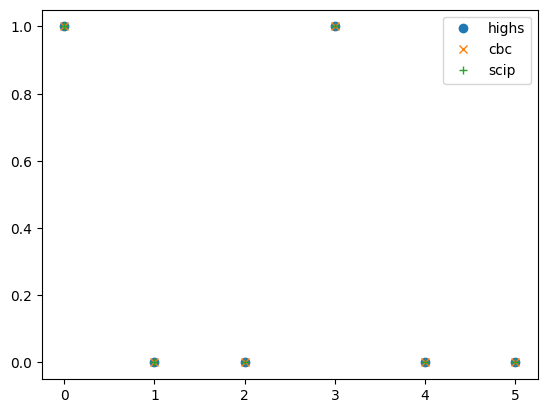

In [3]:
from matplotlib import pyplot as plt

marks = {
    "highs": "o",
    "cbc": "x",
    "scip": "+",
}

for name, solution in solutions.items():
    x = solution.extract_decision_variables("x")
    subscripts = [key[0] for key in x.keys()]
    plt.plot(subscripts, x.values(), marks[name], label=name)

plt.legend()

分析する作業によっては `decision_variables` で得られる `pandas.DataFrame` を縦に結合すると便利です。

In [4]:
import pandas

decision_variables = pandas.concat([
    solution.decision_variables.assign(solver=solver)
    for solver, solution in solutions.items()
])
decision_variables

kind  lower  upper name subscripts description substituted_value  value  \
id                                                                              
0   binary    0.0    1.0    x        [0]        <NA>              <NA>    1.0   
1   binary    0.0    1.0    x        [1]        <NA>              <NA>    0.0   
2   binary    0.0    1.0    x        [2]        <NA>              <NA>    0.0   
3   binary    0.0    1.0    x        [3]        <NA>              <NA>    1.0   
4   binary    0.0    1.0    x        [4]        <NA>              <NA>    0.0   
5   binary    0.0    1.0    x        [5]        <NA>              <NA>    0.0   
0   binary    0.0    1.0    x        [0]        <NA>              <NA>    1.0   
1   binary    0.0    1.0    x        [1]        <NA>              <NA>    0.0   
2   binary    0.0    1.0    x        [2]        <NA>              <NA>    0.0   
3   binary    0.0    1.0    x        [3]        <NA>              <NA>    1.0   
4   binary    0.0    1.0    x        [4]        <NA>              <NA>    0.0   
5   binary    0.0    1.0    x        [5]        <NA>              <NA>    0.0   
0   binary    0.0    1.0    x        [0]        <NA>              <NA>    1.0   
1   binary    0.0    1.0    x        [1]        <NA>              <NA>    0.0   
2   binary    0.0    1.0    x        [2]        <NA>              <NA>    0.0   
3   binary    0.0    1.0    x        [3]        <NA>              <NA>    1.0   
4   binary    0.0    1.0    x        [4]        <NA>              <NA>    0.0   
5   binary    0.0    1.0    x        [5]        <NA>              <NA>    0.0   

   solver  
id         
0   highs  
1   highs  
2   highs  
3   highs  
4   highs  
5   highs  
0     cbc  
1     cbc  
2     cbc  
3     cbc  
4     cbc  
5     cbc  
0    scip  
1    scip  
2    scip  
3    scip  
4    scip  
5    scip